## Capstone Project - Winonsin Breast Cancer Diagnosis Deep Learning Revisited






#### Import necessary libraries

In [19]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
# from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

#### Load in WBCD dataset

In [20]:
# Load the Boston housing dataset
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?', header=None, index_col=['ID'], names = headers)
data = data.reset_index(drop=True)

#### Handle missing data
* There are 16 Bare Nuclei entries missing and marked as "?". Those question marks were replaced as NaN during data loading. 
* All the NaN entries are filled with zero.

In [21]:
data = data.fillna(0)

In [22]:
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


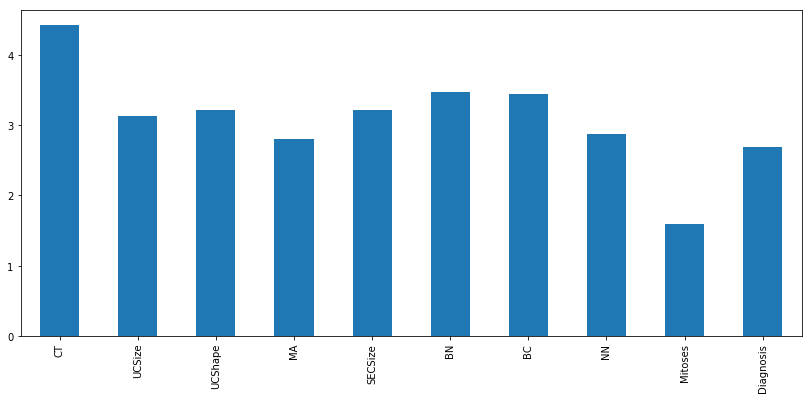

In [23]:
# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
data_mean = data.describe().loc['mean']
data_mean.plot(kind='bar', figsize=(14,6))

In [24]:
data_B = data[data['Diagnosis'] == 2]
data_B.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,2.956332,1.325328,1.443231,1.364629,2.120087,1.305677,2.100437,1.290393,1.063319,2.0
std,1.674318,0.907694,0.997836,0.996830,0.917130,1.182666,1.080339,1.058856,0.501995,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.0
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.0
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.0
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,9.000000,8.000000,2.0


In [25]:
data_M = data[data['Diagnosis'] == 4]
data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,7.195021,6.572614,6.560166,5.547718,5.298755,7.564315,5.979253,5.863071,2.589212,4.0
std,2.428849,2.719512,2.562045,3.210465,2.451606,3.180182,2.273852,3.350672,2.557939,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.0
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000,4.0
75%,10.000000,10.000000,9.000000,8.000000,6.000000,10.000000,7.000000,10.000000,3.000000,4.0
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.0


#### Define a data generation function with random noise

In [26]:
def generateData(data1):
    # make a copy of data
    data2 = data1.copy()

    # separate labels from features
    diagnosis2 = data2['Diagnosis'] # labels
    features2 = data2.drop(['Diagnosis'], axis = 1)
    features2_headers = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]

    mean, sigma = 0, 0.1 
    # creating a noise with the same dimension as the dataset 
    noise = np.random.normal(mean, sigma, features2.shape) 
    features2 = features2.apply(pd.to_numeric, errors='ignore')
    features2_with_noise = features2.add(pd.DataFrame(noise, columns = features2_headers), fill_value=0)
    data2 = pd.concat([features2_with_noise, pd.DataFrame(diagnosis2)], axis = 1)
    
    return data2

In [27]:
data_M_copy = data_M.copy();

new_data_M = generateData(data_M_copy)
data_M = data_M.append(new_data_M, ignore_index=True)

data_M = data_M[data_M['Diagnosis'] >= 4.0]

data_M.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.0
mean,7.193746,6.565510,6.559380,5.547058,5.298187,7.563744,5.982169,5.860477,2.585043,4.0
std,2.430593,2.715280,2.561194,3.208838,2.447647,3.175694,2.271545,3.348577,2.555697,0.0
min,0.877364,0.902415,1.000000,0.737828,1.000000,0.000000,0.850076,0.756351,0.804398,4.0
25%,5.000000,4.000000,4.020860,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,4.0
50%,7.973160,6.000000,6.182281,5.000000,5.000000,9.968276,6.952952,6.000000,1.000000,4.0
75%,10.000000,9.952342,9.000000,8.032085,6.113752,10.000000,7.161924,9.819455,3.000000,4.0
max,10.221379,10.129889,10.162012,10.162302,10.231698,10.196806,10.039939,10.262111,10.202234,4.0


In [28]:
data = data_B.append(data_M, ignore_index=True)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,5.129133,4.012315,4.066618,3.509236,3.749709,4.514600,4.090857,3.633777,1.843607,3.025532
std,2.980162,3.323456,3.223542,3.183240,2.450377,3.954952,2.641912,3.393088,2.011860,1.000206
min,0.877364,0.902415,1.000000,0.737828,1.000000,0.000000,0.850076,0.756351,0.804398,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,4.000000
75%,8.000000,6.928148,7.000000,5.083787,5.000000,10.000000,7.000000,6.000000,1.066814,4.000000
max,10.221379,10.129889,10.162012,10.162302,10.231698,10.196806,10.039939,10.262111,10.202234,4.000000


#### Add the new generated dataset into the existing dataset

In [29]:
data_copy = data;

new_data = generateData(data_copy)
data = data.append(new_data, ignore_index=True)

data = data.fillna(0)

print("data size = ", data.shape[0])

('data size = ', 1880)


#### Scale dataset to the range of [0, 1]

In [30]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ["Diagnosis","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
data[numerical] = scaler.fit_transform(data[numerical])

#### Separate Labels/Classes from Features

In [31]:
diagnosis = data['Diagnosis']
features = data.drop(['Diagnosis'], axis = 1)

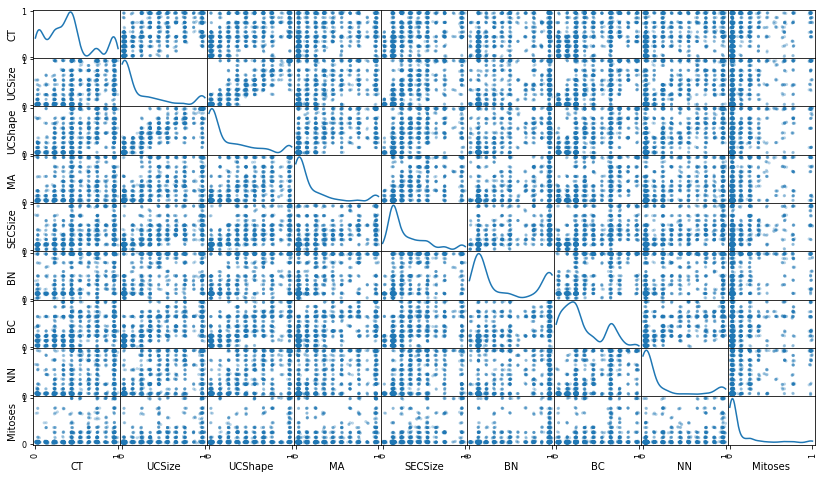

In [32]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

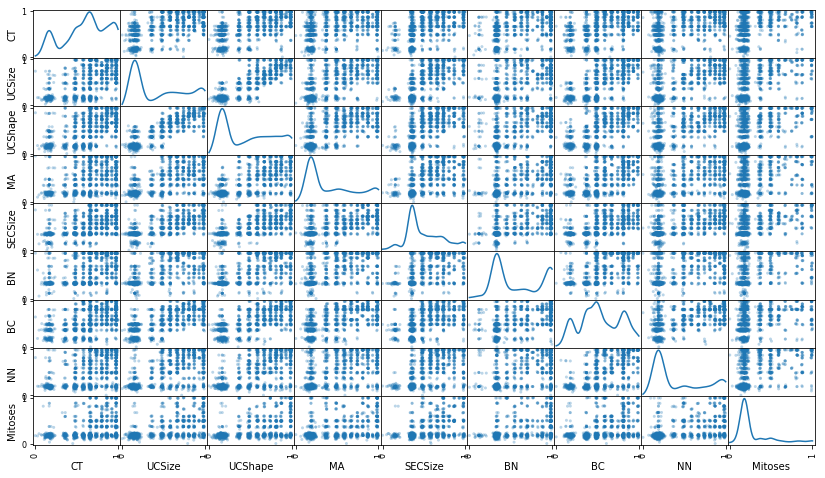

In [33]:
# Scale the data using squared root transformation
sqrt_features = features.copy()

for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.sqrt(sqrt_features[feature_name]) 
    
# sqrt_features = scaler.fit_transform(sqrt_features)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(pd.DataFrame(sqrt_features), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# convert numpy ndarray into Pandas DataFrame
features = pd.DataFrame(sqrt_features)

#### Split dataset into training and testing datasets

In [34]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.25, random_state=42)

#### Reindex 

In [35]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Convert Pandas DataFrame to Numpy ndarray
* This conversion is necessary because Pandas DataFrame is not consist with Keras API.

In [36]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

#### Classify dataset using Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

score = rfc.score(X_test, y_test)
print("score = ", score)

('score = ', 0.98297872340425529)


#### Deep learning

In [38]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
import keras
import keras.utils
from keras import utils as np_utils

Using TensorFlow backend.


#### Define NN Architecture
* add Dropout(0.5) does not produce noticable performance in accuracy once the epochs >= 500.

In [39]:
model = Sequential()

#Define your architecture.
model.add(Dense(9, activation='relu', input_dim=9))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(5,)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


#### Compile NN Model

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

#### Train NN Model

In [41]:
model.fit(X_train, y_train, epochs=500, batch_size=16) # (500, 16) = 0.974286, 32 - 0.968571

Epoch 1/500
1410/1410 [==============================] - 0s - loss: 0.7516 - binary_accuracy: 0.4929     
Epoch 2/500
1410/1410 [==============================] - 0s - loss: 0.6766 - binary_accuracy: 0.5220     
Epoch 3/500
1410/1410 [==============================] - 0s - loss: 0.6432 - binary_accuracy: 0.5766     
Epoch 4/500
1410/1410 [==============================] - 0s - loss: 0.6307 - binary_accuracy: 0.6248     
Epoch 5/500
1410/1410 [==============================] - 0s - loss: 0.5952 - binary_accuracy: 0.7199     
Epoch 6/500
1410/1410 [==============================] - 0s - loss: 0.5589 - binary_accuracy: 0.7532     
Epoch 7/500
1410/1410 [==============================] - 0s - loss: 0.5284 - binary_accuracy: 0.8043     
Epoch 8/500
1410/1410 [==============================] - 0s - loss: 0.5080 - binary_accuracy: 0.8071     
Epoch 9/500
1410/1410 [==============================] - 0s - loss: 0.4838 - binary_accuracy: 0.8326     
Epoch 10/500
1410/1410 [======================

1410/1410 [==============================] - 0s - loss: 0.2686 - binary_accuracy: 0.9156     
Epoch 78/500
1410/1410 [==============================] - 0s - loss: 0.2452 - binary_accuracy: 0.9241     
Epoch 79/500
1410/1410 [==============================] - 0s - loss: 0.2637 - binary_accuracy: 0.9191     
Epoch 80/500
1410/1410 [==============================] - 0s - loss: 0.2493 - binary_accuracy: 0.9241     
Epoch 81/500
1410/1410 [==============================] - 0s - loss: 0.2670 - binary_accuracy: 0.9163     
Epoch 82/500
1410/1410 [==============================] - 0s - loss: 0.2711 - binary_accuracy: 0.9128     
Epoch 83/500
1410/1410 [==============================] - 0s - loss: 0.2663 - binary_accuracy: 0.9113     
Epoch 84/500
1410/1410 [==============================] - 0s - loss: 0.2368 - binary_accuracy: 0.9262     
Epoch 85/500
1410/1410 [==============================] - 0s - loss: 0.2760 - binary_accuracy: 0.9113     
Epoch 86/500
1410/1410 [==========================

1410/1410 [==============================] - 0s - loss: 0.2420 - binary_accuracy: 0.9270     
Epoch 154/500
1410/1410 [==============================] - 0s - loss: 0.2918 - binary_accuracy: 0.9121     
Epoch 155/500
1410/1410 [==============================] - 0s - loss: 0.2249 - binary_accuracy: 0.9298     
Epoch 156/500
1410/1410 [==============================] - 0s - loss: 0.2560 - binary_accuracy: 0.9248     
Epoch 157/500
1410/1410 [==============================] - 0s - loss: 0.2235 - binary_accuracy: 0.9362     
Epoch 158/500
1410/1410 [==============================] - 0s - loss: 0.2224 - binary_accuracy: 0.9340     
Epoch 159/500
1410/1410 [==============================] - 0s - loss: 0.2688 - binary_accuracy: 0.9142     
Epoch 160/500
1410/1410 [==============================] - 0s - loss: 0.2442 - binary_accuracy: 0.9291     
Epoch 161/500
1410/1410 [==============================] - 0s - loss: 0.2710 - binary_accuracy: 0.9099     
Epoch 162/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2493 - binary_accuracy: 0.9184     
Epoch 229/500
1410/1410 [==============================] - 0s - loss: 0.2087 - binary_accuracy: 0.9397     
Epoch 230/500
1410/1410 [==============================] - 0s - loss: 0.2345 - binary_accuracy: 0.9319     
Epoch 231/500
1410/1410 [==============================] - 0s - loss: 0.2472 - binary_accuracy: 0.9262     
Epoch 232/500
1410/1410 [==============================] - 0s - loss: 0.2185 - binary_accuracy: 0.9376     
Epoch 233/500
1410/1410 [==============================] - 0s - loss: 0.2647 - binary_accuracy: 0.9213     
Epoch 234/500
1410/1410 [==============================] - 0s - loss: 0.2454 - binary_accuracy: 0.9213     
Epoch 235/500
1410/1410 [==============================] - 0s - loss: 0.2538 - binary_accuracy: 0.9199     
Epoch 236/500
1410/1410 [==============================] - 0s - loss: 0.2572 - binary_accuracy: 0.9248     
Epoch 237/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2623 - binary_accuracy: 0.9170     
Epoch 304/500
1410/1410 [==============================] - 0s - loss: 0.2310 - binary_accuracy: 0.9291     
Epoch 305/500
1410/1410 [==============================] - 0s - loss: 0.2476 - binary_accuracy: 0.9234     
Epoch 306/500
1410/1410 [==============================] - 0s - loss: 0.2381 - binary_accuracy: 0.9284     
Epoch 307/500
1410/1410 [==============================] - 0s - loss: 0.2762 - binary_accuracy: 0.9199     
Epoch 308/500
1410/1410 [==============================] - 0s - loss: 0.2378 - binary_accuracy: 0.9248     
Epoch 309/500
1410/1410 [==============================] - 0s - loss: 0.2279 - binary_accuracy: 0.9312     
Epoch 310/500
1410/1410 [==============================] - 0s - loss: 0.2512 - binary_accuracy: 0.9227     
Epoch 311/500
1410/1410 [==============================] - 0s - loss: 0.2496 - binary_accuracy: 0.9262     
Epoch 312/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2176 - binary_accuracy: 0.9348     
Epoch 379/500
1410/1410 [==============================] - 0s - loss: 0.2168 - binary_accuracy: 0.9340     
Epoch 380/500
1410/1410 [==============================] - 0s - loss: 0.2531 - binary_accuracy: 0.9298     
Epoch 381/500
1410/1410 [==============================] - 0s - loss: 0.2722 - binary_accuracy: 0.9121     
Epoch 382/500
1410/1410 [==============================] - 0s - loss: 0.2312 - binary_accuracy: 0.9298     
Epoch 383/500
1410/1410 [==============================] - 0s - loss: 0.2414 - binary_accuracy: 0.9277     
Epoch 384/500
1410/1410 [==============================] - 0s - loss: 0.2232 - binary_accuracy: 0.9348     
Epoch 385/500
1410/1410 [==============================] - 0s - loss: 0.2325 - binary_accuracy: 0.9369     
Epoch 386/500
1410/1410 [==============================] - 0s - loss: 0.2476 - binary_accuracy: 0.9234     
Epoch 387/500
1410/1410 [=================

1410/1410 [==============================] - 0s - loss: 0.2587 - binary_accuracy: 0.9270     
Epoch 454/500
1410/1410 [==============================] - 0s - loss: 0.2490 - binary_accuracy: 0.9234     
Epoch 455/500
1410/1410 [==============================] - 0s - loss: 0.2267 - binary_accuracy: 0.9298     
Epoch 456/500
1410/1410 [==============================] - 0s - loss: 0.2436 - binary_accuracy: 0.9291     
Epoch 457/500
1410/1410 [==============================] - 0s - loss: 0.2530 - binary_accuracy: 0.9241     
Epoch 458/500
1410/1410 [==============================] - 0s - loss: 0.2609 - binary_accuracy: 0.9262     
Epoch 459/500
1410/1410 [==============================] - 0s - loss: 0.2395 - binary_accuracy: 0.9333     
Epoch 460/500
1410/1410 [==============================] - 0s - loss: 0.2429 - binary_accuracy: 0.9241     
Epoch 461/500
1410/1410 [==============================] - 0s - loss: 0.2611 - binary_accuracy: 0.9270     
Epoch 462/500
1410/1410 [=================

#### Test NN Model

In [42]:
score = model.evaluate(X_test, y_test, batch_size=16) # 16 - 0.974286, 32 - 0.968571
print("score = ", score)

 16/470 [>.............................] - ETA: 0s('score = ', [0.19497156474501529, 0.97234042553191491])


#### Draw ROC Curve

 32/470 [=>............................] - ETA: 0s

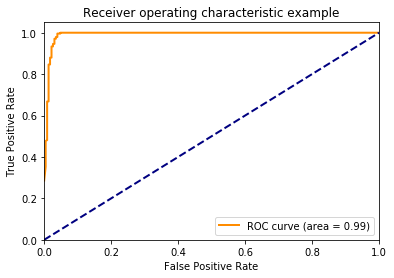

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

y_pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()